In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats

# Set up the factors list for use throughout the analysis
factors = ["Mkt-RF"]

# Full path to data file
data_file = '/Users/comecosmolabautiere/Desktop/Yale/Fall Semester/Fall 1/Quant Investing/Assignment/Quantitative-Investing/data/Problem_Set3.xlsx'

# Load the 49 industry portfolios
vw49 = pd.read_excel(data_file, sheet_name='49_Industry_Portfolios', header=6)
vw49 = vw49.loc[:, :'Other']  # Keep only up to 'Other' column
vw49 = vw49.replace([-99.99, -999], np.nan).dropna(how="all")

# Load the market data
market = pd.read_excel(data_file, sheet_name='Market_proxy', header=5)
market = market.replace([-99.99, -999], np.nan).dropna(how="all")

# Clean the date columns and set index
vw49 = vw49.rename(columns={vw49.columns[0]: "date"})
vw49["date"] = pd.to_datetime(vw49["date"].dropna().astype(int).astype(str), format="%Y%m")
vw49 = vw49.set_index("date")

market = market.rename(columns={market.columns[0]: "date"})
market["date"] = pd.to_datetime(market["date"].dropna().astype(int).astype(str), format="%Y%m")
market = market.set_index("date")

# Load 25 Size-BE/ME portfolios data - with careful handling of multi-level headers
try:
    # Read in raw data first to understand structure
    raw_25 = pd.read_excel(data_file, sheet_name='25_Size_BEME_Portfolios', header=None)
    
    # Skip the first 2 rows that contain headers
    beme25 = pd.read_excel(data_file, sheet_name='25_Size_BEME_Portfolios', header=2)
    
    # Rename date column 
    beme25 = beme25.rename(columns={beme25.columns[0]: "date"})
    
    # Convert date and set as index
    beme25["date"] = pd.to_datetime(beme25["date"].astype(int).astype(str), format="%Y%m")
    beme25 = beme25.set_index("date")
    
    # Replace missing values
    beme25 = beme25.replace([-99.99, -999], np.nan)
    
    # Get first 25 columns as our portfolios
    portfolios25 = list(beme25.columns[:25])
    print(f"Successfully loaded 25 Size-BE/ME portfolios.")
    print(f"Portfolio columns: {portfolios25[:5]}... (showing first 5 of {len(portfolios25)})")
    
except Exception as e:
    print(f"Error loading 25 Size-BE/ME portfolios: {e}")
    beme25 = None
    portfolios25 = []

# Merge the data
if portfolios25:
    # First merge market with industry data
    temp = pd.merge(market, vw49, on="date", how="inner")
    # Then merge with size-BE/ME portfolios
    data = pd.merge(temp, beme25, left_index=True, right_index=True)
    print(f"Successfully merged data with {len(portfolios25)} size-BE/ME portfolios")
else:
    # Just merge market with industry data if no portfolios25
    data = pd.merge(market, vw49, on="date", how="inner")
    print("No 25 size-BE/ME portfolios loaded")

# Get list of industry portfolios
portfolios49 = list(vw49.columns[:49])

# Convert to excess returns
data[portfolios49] = data[portfolios49].subtract(data["RF"], axis=0)
if portfolios25:
    data[portfolios25] = data[portfolios25].subtract(data["RF"], axis=0)
    print(f"Converted all returns to excess returns by subtracting risk-free rate")

Successfully loaded 25 Size-BE/ME portfolios.
Portfolio columns: ['Low', 2, 3, 4, 'High']... (showing first 5 of 25)
Successfully merged data with 25 size-BE/ME portfolios
Converted all returns to excess returns by subtracting risk-free rate


In [80]:

print(data.columns[:10])


Index(['Mkt-RF', 'RF', 'Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys', 'Fun',
       'Books'],
      dtype='object')


In [81]:
import os
print("Current working directory:", os.getcwd())
print("Files in current directory:", os.listdir('.'))
if os.path.exists('data'):
    print("Files in data directory:", os.listdir('data'))
else:
    print("data directory does not exist in current working directory")
    
# Check if file exists in parent directory
if os.path.exists('../data'):
    print("Files in ../data directory:", os.listdir('../data'))
else:
    print("../data directory does not exist either")

Current working directory: /Users/comecosmolabautiere/Desktop/Yale/Fall Semester/Fall 1/Quant Investing/Assignment/Quantitative-Investing/Problem_Set_3
Files in current directory: ['QI_PS3.ipynb', 'assignment.py']
data directory does not exist in current working directory
Files in ../data directory: ['~$Problem_Set3.xlsx', '.DS_Store', 'Problem_Set2_2025.xlsx', 'Problem_Set3.xlsx', 'Problem_Set1_2025.xlsx']


In [82]:
# Question A
# lambda_zero should be equal to the risk free rate, while lambda_m should be equal to the market excess return (market return minus risk free rate)
# For Black CAPM then 𝜆0 is the return of the zero-beta portfolio and λM is the market return minus zero-beta portfolio return.

In [83]:
# Question B) 1.
factors = ["Mkt-RF"]
portfolios49 = list(vw49.columns[:49])
portfolios25 = list(beme25.columns[:25]) if beme25 is not None else []

results = pd.DataFrame(index=portfolios49, columns=["alpha", "beta_MKT"])

for p in portfolios49:
    Y = data[p]  
    X = sm.add_constant(data[factors])  

    mask = Y.notna() & X[factors].notna().all(axis=1)
    Y_clean = Y[mask]
    X_clean = X[mask]
    
    model = sm.OLS(Y_clean, X_clean)
    res = model.fit()
    results.loc[p, "alpha"] = res.params["const"]
    results.loc[p, "beta_MKT"] = res.params["Mkt-RF"]

print(results.head(49))

          alpha  beta_MKT
Agric  0.079961   0.91715
Food   0.244833  0.725443
Soda   0.341172  0.831407
Beer   0.317082  0.942062
Smoke  0.482244  0.628665
Toys  -0.043625  1.207596
Fun    0.043203  1.421768
Books -0.007649  1.116615
Hshld  0.057837  0.902271
Clths  0.117064  0.813177
Hlth   0.050291  1.122114
MedEq  0.293181  0.837705
Drugs  0.281583   0.83652
Chems  0.103032  1.042579
Rubbr  0.127926  1.212117
Txtls -0.017285  1.138909
BldMt  -0.03964  1.159646
Cnstr -0.153424  1.355373
Steel -0.243096  1.357006
FabPr -0.258952  1.112992
Mach  -0.032445  1.243169
ElcEq  0.057924  1.284064
Autos -0.012242  1.252084
Aero   0.276474  1.306059
Ships -0.016346  1.167509
Guns    0.38419  0.838329
Gold   0.294373  0.604977
Mines  0.101098  0.974484
Coal  -0.050477   1.29982
Oil    0.185034  0.868141
Util   0.093951  0.778292
Telcm  0.153157   0.66148
PerSv -0.056087  1.089987
BusSv  0.112768  0.889436
Hardw  0.198467  1.115375
Softw  -0.26037   1.63629
Chips -0.029707  1.343525
LabEq  0.184

In [84]:
# Question B) 2.
lambda_results = pd.DataFrame(columns=["lambda_0", "lambda_1"])

for t in data.index:   
    Y = data.loc[t, portfolios49]                  
    X = sm.add_constant(results["beta_MKT"].astype(float))  

    mask = Y.notna() & X["beta_MKT"].notna()  
    Y_clean = Y[mask]
    X_clean = X.loc[mask]     

    model = sm.OLS(Y_clean, X_clean)
    res = model.fit()
    lambda_results.loc[t, "lambda_0"] = res.params["const"]
    lambda_results.loc[t, "lambda_1"] = res.params["beta_MKT"]
    
print(lambda_results.head(1000))

lambda_mean = lambda_results.mean()   
T = len(lambda_results)               
lambda_se = lambda_results.std(ddof=1) / np.sqrt(T)   

lambda_tstat = lambda_mean / lambda_se

lambda_summary = pd.DataFrame({
    "lambda_mean": lambda_mean,
    "std_error": lambda_se,
    "t_stat": lambda_tstat
})

print(lambda_summary)

            lambda_0  lambda_1
1926-07-01  2.934741  0.011544
1926-08-01  4.485903 -0.292781
1926-09-01  3.629945 -3.802821
1926-10-01   3.04606 -6.209947
1926-11-01  5.342548 -2.354092
...              ...       ...
2009-06-01 -4.367412  3.622126
2009-07-01  -0.22296  9.330926
2009-08-01 -3.176515  6.506852
2009-09-01  5.096472 -0.015345
2009-10-01 -1.083158 -2.633949

[1000 rows x 2 columns]
         lambda_mean std_error    t_stat
lambda_0    0.528874  0.187972  2.813586
lambda_1     0.22154  0.252683  0.876753


In [85]:
mean_returns49 = data[portfolios49].mean()

In [86]:
## Question C
lambda_results_mean = pd.DataFrame(columns=[
    "lambda_0_mean", "lambda_1_mean",
    "lambda_0_se", "lambda_1_se",
    "lambda_0_tstat", "lambda_1_tstat"
])

Y = mean_returns49                 
X = sm.add_constant(results["beta_MKT"].astype(float))  
model = sm.OLS(Y, X)
res = model.fit()
lambda_results_mean.loc[t, "lambda_0_mean"] = res.params["const"]
lambda_results_mean.loc[t, "lambda_1_mean"] = res.params["beta_MKT"]

lambda_results_mean.loc[t, "lambda_0_se"] = res.bse["const"]
lambda_results_mean.loc[t, "lambda_1_se"] = res.bse["beta_MKT"]

lambda_results_mean.loc[t, "lambda_0_tstat"] = res.tvalues["const"]
lambda_results_mean.loc[t, "lambda_1_tstat"] = res.tvalues["beta_MKT"]

print(lambda_results_mean)


           lambda_0_mean lambda_1_mean lambda_0_se lambda_1_se lambda_0_tstat  \
2016-11-01      0.603226      0.134469    0.098534    0.089665       6.121994   

           lambda_1_tstat  
2016-11-01       1.499681  


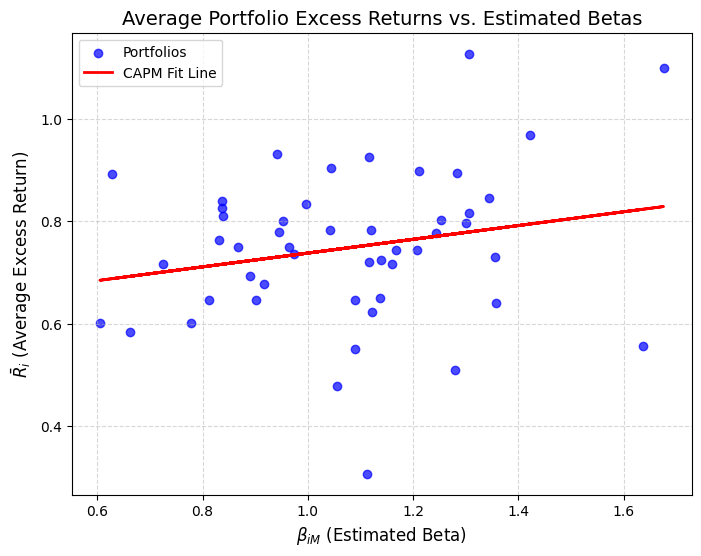

np.float64(0.13446907201377903)

In [56]:
## Question D
# Ensure numeric and drop missing values
x = pd.to_numeric(results["beta_MKT"], errors='coerce')
y = pd.to_numeric(mean_returns49, errors='coerce')
mask = x.notna() & y.notna()
x_clean, y_clean = x[mask], y[mask]

# Fit OLS regression for the red CAPM line
X_ols = sm.add_constant(x_clean)
model = sm.OLS(y_clean, X_ols).fit()
y_pred = model.predict(X_ols)
intercept = model.params['const']  # the intercept
slope = model.params[x_clean.name]  # the slope

# Plot
plt.figure(figsize=(8,6))
plt.scatter(x_clean, y_clean, color='blue', alpha=0.7, label='Portfolios')
plt.plot(x_clean, y_pred, color='red', linewidth=2, label='CAPM Fit Line')
plt.xlabel(r'$\beta_{iM}$ (Estimated Beta)', fontsize=12)
plt.ylabel(r'$\bar{R}_i$ (Average Excess Return)', fontsize=12)
plt.title('Average Portfolio Excess Returns vs. Estimated Betas', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

slope

In [87]:
## Question E

lambda_results_extended = pd.DataFrame(columns=["lambda_0_extended", "lambda_1_extended", "lambda_size", "lambda_BEME"])

# Load the full 49 industry portfolios sheet with all columns (returns, size, BE/ME)
vw49_full = pd.read_excel('../data/Problem_Set3.xlsx', sheet_name='49_Industry_Portfolios', header=6)
vw49_full = vw49_full.replace([-99.99, -999], np.nan).dropna(how="all")

# Clean the date column and set index
vw49_full = vw49_full.rename(columns={vw49_full.columns[0]: "date"})
vw49_full["date"] = pd.to_datetime(vw49_full["date"].dropna().astype(int).astype(str), format="%Y%m")
vw49_full = vw49_full.set_index("date")

# Align with our existing data timeframe
vw49_full = vw49_full.loc[data.index]

# Get size columns (columns with .1 suffix, which are the size data)
size_cols = [col for col in vw49_full.columns if col.endswith('.1')][:49]  # Take first 49 to match portfolios
print(f"Size columns found: {len(size_cols)}")

# Get BE/ME columns (columns with .2 suffix, which are the BE/ME data)  
beme_cols = [col for col in vw49_full.columns if col.endswith('.2')][:49]  # Take first 49 to match portfolios
print(f"BE/ME columns found: {len(beme_cols)}")

# Extract size and BE/ME data
size_data = vw49_full[size_cols]
beme_data = vw49_full[beme_cols]

# Handle BE/ME data - convert from yearly to monthly
beme_yearly = beme_data.copy()  
beme_yearly['year'] = beme_yearly.index.year

# Group by year and take first non-NaN value for that year
beme_yearly_avg = beme_yearly.groupby('year').first()

# Create monthly BE/ME data by mapping each month to its year value
beme_monthly = pd.DataFrame(index=data.index)
for i, col in enumerate(beme_cols):
    beme_monthly[col] = data.index.year.map(beme_yearly_avg[col])

# Forward-fill in case the first year is missing
beme_monthly = beme_monthly.ffill()

# Take log of size and BE/ME data
ln_size = np.log(size_data.replace(0, np.nan))  # Replace 0 with NaN before log
ln_BEME = np.log(beme_monthly.replace(0, np.nan))  # Replace 0 with NaN before log

# Calculate averages across time for each portfolio
ln_size_avg = ln_size.mean(axis=0)
ln_BEME_avg = ln_BEME.mean(axis=0)

# Ensure we have the same number of observations for all variables
print(f"Length of portfolios49: {len(portfolios49)}")
print(f"Length of ln_size_avg: {len(ln_size_avg)}")  
print(f"Length of ln_BEME_avg: {len(ln_BEME_avg)}")

# Build the design matrix for cross-sectional regression
Y = mean_returns49.values.astype(float)  
X = np.column_stack([
    np.ones(len(portfolios49)),                                    # Intercept
    results.loc[portfolios49, "beta_MKT"].astype(float).values,   # Beta
    ln_size_avg.values[:len(portfolios49)],                       # ln(Size) - ensure same length
    ln_BEME_avg.values[:len(portfolios49)]                        # ln(BE/ME) - ensure same length
])

print(f"Y shape: {Y.shape}")
print(f"X shape: {X.shape}")

# Run cross-sectional regression
cs_model = sm.OLS(Y, X).fit()
print(cs_model.summary())

Size columns found: 49
BE/ME columns found: 49
Length of portfolios49: 49
Length of ln_size_avg: 49
Length of ln_BEME_avg: 49
Y shape: (49,)
X shape: (49, 4)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     3.774
Date:                Thu, 25 Sep 2025   Prob (F-statistic):             0.0169
Time:                        18:52:45   Log-Likelihood:                 29.603
No. Observations:                  49   AIC:                            -51.21
Df Residuals:                      45   BIC:                            -43.64
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|

In [88]:
## Question F
rows = []
dates = data.index

# Excess returns matrix (T x N for the 49 VW portfolios)
R_ex = data[portfolios49].values

# Betas (same for all t, already estimated)
beta_vec = results.loc[portfolios49, "beta_MKT"].astype(float).values

# ln(size) and ln(BE/ME) from the corrected data above
LS = ln_size.values  # Monthly ln(size) data
LB = ln_BEME.values  # Monthly ln(BE/ME) data

print(f"R_ex shape: {R_ex.shape}")
print(f"beta_vec shape: {beta_vec.shape}")
print(f"LS shape: {LS.shape}")
print(f"LB shape: {LB.shape}")

# Loop over time (each month)
for t in range(R_ex.shape[0]):
    y = R_ex[t, :]        # returns at time t across portfolios
    x1 = beta_vec         # constant across time
    x2 = LS[t, :]         # ln(size) at time t
    x3 = LB[t, :]         # ln(BE/ME) at time t

    # Mask to drop NaN portfolios
    mask = ~np.isnan(y) & ~np.isnan(x1) & ~np.isnan(x2) & ~np.isnan(x3)
    if mask.sum() < 8:
        continue  # skip if too few portfolios available

    # Build regressor matrix: [1, beta, ln(size), ln(BE/ME)]
    X = np.column_stack([
        np.ones(mask.sum()),
        x1[mask],
        x2[mask],
        x3[mask]
    ]).astype(float)

    # OLS via np.linalg.lstsq
    coef, *_ = np.linalg.lstsq(X, y[mask].astype(float), rcond=None)

    # Save results
    rows.append([
        dates[t],
        float(coef[0]),  # γ0
        float(coef[1]),  # γM
        float(coef[2]),  # γsize
        float(coef[3]),  # γB/M
        int(mask.sum())  # number of portfolios used
    ])

# Collect results into comprehensive DataFrame with descriptive names
time_series_risk_premiums = pd.DataFrame(
    rows,
    columns=["observation_date", "intercept_premium", "market_beta_premium", "size_factor_premium", "value_factor_premium", "num_portfolios_used"]
).sort_values("observation_date").reset_index(drop=True)

print()
print("╔" + "═" * 78 + "╗")
print("║" + " " * 20 + "FAMA-MACBETH CROSS-SECTIONAL ANALYSIS" + " " * 19 + "║")
print("╚" + "═" * 78 + "╝")
print()

# Dataset overview with descriptive information
analysis_overview = [
    ["Total Monthly Regressions", f"{len(time_series_risk_premiums):,}"],
    ["Sample Period", f"{time_series_risk_premiums['observation_date'].min().strftime('%b %Y')} to {time_series_risk_premiums['observation_date'].max().strftime('%b %Y')}"],
    ["Average Portfolios per Month", f"{time_series_risk_premiums['num_portfolios_used'].mean():.1f}"],
    ["Regression Type", "Cross-Sectional with Size and Book-to-Market Controls"]
]

print("┌─────────────────────────────┬───────────────────────────────────┐")
print("│        ANALYSIS SUMMARY     │              VALUE                │")
print("├─────────────────────────────┼───────────────────────────────────┤")
for metric_name, metric_value in analysis_overview:
    print(f"│ {metric_name:<27} │ {metric_value:<33} │")
print("└─────────────────────────────┴───────────────────────────────────┘")
print()

print("SAMPLE MONTHLY REGRESSION RESULTS (First & Last 5 Observations)")
print("─" * 70)
display(pd.concat([time_series_risk_premiums.head(5), time_series_risk_premiums.tail(5)]).round(4))
print()

# Calculate time-series statistics with improved variable names
risk_premium_columns = ["intercept_premium", "market_beta_premium", "size_factor_premium", "value_factor_premium"]
monthly_risk_premiums = time_series_risk_premiums[risk_premium_columns]

# Compute comprehensive statistics
average_intercept_premium = monthly_risk_premiums['intercept_premium'].mean()
average_market_beta_premium = monthly_risk_premiums['market_beta_premium'].mean() 
average_size_factor_premium = monthly_risk_premiums['size_factor_premium'].mean()
average_value_factor_premium = monthly_risk_premiums['value_factor_premium'].mean()

standard_error_intercept = monthly_risk_premiums['intercept_premium'].std() / np.sqrt(len(monthly_risk_premiums))
standard_error_market_beta = monthly_risk_premiums['market_beta_premium'].std() / np.sqrt(len(monthly_risk_premiums))
standard_error_size_factor = monthly_risk_premiums['size_factor_premium'].std() / np.sqrt(len(monthly_risk_premiums))
standard_error_value_factor = monthly_risk_premiums['value_factor_premium'].std() / np.sqrt(len(monthly_risk_premiums))

t_statistic_intercept = average_intercept_premium / standard_error_intercept
t_statistic_market_beta = average_market_beta_premium / standard_error_market_beta
t_statistic_size_factor = average_size_factor_premium / standard_error_size_factor
t_statistic_value_factor = average_value_factor_premium / standard_error_value_factor

p_value_intercept = 2 * (1 - scipy.stats.t.cdf(abs(t_statistic_intercept), len(monthly_risk_premiums)-1))
p_value_market_beta = 2 * (1 - scipy.stats.t.cdf(abs(t_statistic_market_beta), len(monthly_risk_premiums)-1)) 
p_value_size_factor = 2 * (1 - scipy.stats.t.cdf(abs(t_statistic_size_factor), len(monthly_risk_premiums)-1))
p_value_value_factor = 2 * (1 - scipy.stats.t.cdf(abs(t_statistic_value_factor), len(monthly_risk_premiums)-1))

print()
print("RISK PREMIUM ESTIMATES AND STATISTICAL INFERENCE")
print("═" * 65)

# Create comprehensive factor analysis dictionary
factor_analysis_results = {
    'Intercept (Alpha)': {
        'risk_premium': average_intercept_premium, 
        'standard_error': standard_error_intercept, 
        't_statistic': t_statistic_intercept, 
        'p_value': p_value_intercept
    },
    'Market Beta Risk Premium': {
        'risk_premium': average_market_beta_premium, 
        'standard_error': standard_error_market_beta, 
        't_statistic': t_statistic_market_beta, 
        'p_value': p_value_market_beta
    },
    'Size Factor Risk Premium': {
        'risk_premium': average_size_factor_premium, 
        'standard_error': standard_error_size_factor, 
        't_statistic': t_statistic_size_factor, 
        'p_value': p_value_size_factor
    },
    'Value Factor Risk Premium': {
        'risk_premium': average_value_factor_premium, 
        'standard_error': standard_error_value_factor, 
        't_statistic': t_statistic_value_factor, 
        'p_value': p_value_value_factor
    }
}

comprehensive_results_table = pd.DataFrame({
    'Monthly_Risk_Premium_%': [average_intercept_premium, average_market_beta_premium, average_size_factor_premium, average_value_factor_premium],
    'Standard_Error': [standard_error_intercept, standard_error_market_beta, standard_error_size_factor, standard_error_value_factor],
    'T_Statistic': [t_statistic_intercept, t_statistic_market_beta, t_statistic_size_factor, t_statistic_value_factor],
    'P_Value_Two_Tailed': [p_value_intercept, p_value_market_beta, p_value_size_factor, p_value_value_factor]
}, index=list(factor_analysis_results.keys()))

# Professional table formatting without emojis
print("┌─────────────────────────┬─────────────┬─────────────┬─────────────┬──────────┐")
print("│      Risk Factor        │   Premium   │  Std Error  │  T-Statistic│ P-Value  │")
print("├─────────────────────────┼─────────────┼─────────────┼─────────────┼──────────┤")

for factor_description, statistical_results in factor_analysis_results.items():
    risk_premium = statistical_results['risk_premium']
    standard_error = statistical_results['standard_error'] 
    t_statistic = statistical_results['t_statistic']
    p_value = statistical_results['p_value']
    
    print(f"│ {factor_description:<23} │ {risk_premium:>10.4f}% │ {standard_error:>10.4f}  │ {t_statistic:>10.3f}  │ {p_value:>7.4f} │")

print("└─────────────────────────┴─────────────┴─────────────┴─────────────┴──────────┘")

print()
print("STATISTICAL SIGNIFICANCE INTERPRETATION:")
print("─" * 55)
for factor_description, statistical_results in factor_analysis_results.items():
    t_statistic = statistical_results['t_statistic']
    risk_premium = statistical_results['risk_premium']
    
    if abs(t_statistic) > 2.576:
        significance_level = "HIGHLY SIGNIFICANT (p < 0.01)"
        evidence_strength = "Strong statistical evidence"
    elif abs(t_statistic) > 1.96:
        significance_level = "SIGNIFICANT (p < 0.05)"
        evidence_strength = "Moderate statistical evidence"
    elif abs(t_statistic) > 1.645:
        significance_level = "WEAKLY SIGNIFICANT (p < 0.10)"
        evidence_strength = "Weak statistical evidence"
    else:
        significance_level = "NOT SIGNIFICANT (p >= 0.10)"
        evidence_strength = "No significant statistical evidence"
    
    premium_direction = "positive" if risk_premium > 0 else "negative"
    print(f"{factor_description}: {risk_premium:+.4f}% ({premium_direction}) - {significance_level}")

print("\nSignificance Levels: *** p<0.01, ** p<0.05, * p<0.10")

R_ex shape: (1085, 49)
beta_vec shape: (49,)
LS shape: (1085, 49)
LB shape: (1085, 49)

╔══════════════════════════════════════════════════════════════════════════════╗
║                    FAMA-MACBETH CROSS-SECTIONAL ANALYSIS                   ║
╚══════════════════════════════════════════════════════════════════════════════╝

┌─────────────────────────────┬───────────────────────────────────┐
│        ANALYSIS SUMMARY     │              VALUE                │
├─────────────────────────────┼───────────────────────────────────┤
│ Total Monthly Regressions   │ 1,085                             │
│ Sample Period               │ Jul 1926 to Nov 2016              │
│ Average Portfolios per Month │ 46.3                              │
│ Regression Type             │ Cross-Sectional with Size and Book-to-Market Controls │
└─────────────────────────────┴───────────────────────────────────┘

SAMPLE MONTHLY REGRESSION RESULTS (First & Last 5 Observations)
────────────────────────────────────────

,observation_date,intercept_premium,market_beta_premium,size_factor_premium,value_factor_premium,num_portfolios_used
0,1926-07-01,-4.8823,0.9318,2.4030,7.1309,40
1,1926-08-01,8.1808,-3.4094,0.4341,11.9028,40
2,1926-09-01,-2.9219,-2.2978,1.5501,1.7114,40
3,1926-10-01,-4.3564,-4.8519,1.9678,4.2052,40
4,1926-11-01,6.1618,-2.2621,-0.3679,-1.9842,40
1080,2016-07-01,23.4451,2.2745,-2.2880,1.4582,49
1081,2016-08-01,-13.2525,6.5351,0.6610,-0.3784,49
1082,2016-09-01,-2.6288,1.4437,0.3281,1.6355,49
1083,2016-10-01,-21.9528,2.2816,1.9535,-0.1620,49
1084,2016-11-01,14.1485,8.3067,-1.5093,3.9892,49




RISK PREMIUM ESTIMATES AND STATISTICAL INFERENCE
═════════════════════════════════════════════════════════════════
┌─────────────────────────┬─────────────┬─────────────┬─────────────┬──────────┐
│      Risk Factor        │   Premium   │  Std Error  │  T-Statistic│ P-Value  │
├─────────────────────────┼─────────────┼─────────────┼─────────────┼──────────┤
│ Intercept (Alpha)       │     0.7275% │     0.3231  │      2.252  │  0.0245 │
│ Market Beta Risk Premium │     0.1405% │     0.2180  │      0.645  │  0.5193 │
│ Size Factor Risk Premium │    -0.0413% │     0.0418  │     -0.990  │  0.3225 │
│ Value Factor Risk Premium │    -0.0570% │     0.0613  │     -0.930  │  0.3526 │
└─────────────────────────┴─────────────┴─────────────┴─────────────┴──────────┘

STATISTICAL SIGNIFICANCE INTERPRETATION:
───────────────────────────────────────────────────────
Intercept (Alpha): +0.7275% (positive) - SIGNIFICANT (p < 0.05)
Market Beta Risk Premium: +0.1405% (positive) - NOT SIGNIFICANT (p >= 0.1

In [47]:
import scipy.stats

          alpha  beta_MKT
-8.62 -0.482666  1.630266
-3.75 -0.210807  1.410183
-5.67  0.115273  1.373216
 5.72  0.356318  1.271025
-2.55  0.463657  1.379904
-1.80 -0.200977  1.266302
-3.27   0.13455  1.226805
-5.07  0.215103  1.197744
-8.05  0.306102  1.212517
-1.32  0.360561  1.379189
-5.12 -0.104576   1.24535
-2.56  0.175322  1.125784
 0.27  0.205453  1.124559
-1.98  0.260415  1.159741
-3.14  0.265844  1.378122
-3.34  0.002719  1.092179
-2.66  0.046675  1.079798
-2.03  0.140494  1.115654
-3.11   0.22222  1.154469
-5.35   0.11045  1.420328
-2.74 -0.008201  0.955388
-3.01  0.001259  0.949513
-2.24  0.073037  0.968559
-4.67 -0.070005  1.108139
-5.81  0.110522  1.311659
             lambda_0   lambda_1
1926-11-01   3.003493  -0.569725
1926-12-01  -3.392238    4.65988
1927-01-01  -3.317567   3.153259
1927-02-01  -0.935014   5.373435
1927-03-01  -1.674419   0.203052
...               ...        ...
2009-10-01  11.755445 -14.620132
2009-11-01  10.798244  -5.838152
2009-12-01  -3.181685    7.

=== Analysis of 25 Size-BE/ME Portfolios ===
Portfolio names: ['Low', 2, 3, 4, 'High']... (showing first 5 of 25)

Part b) 1. Time-series regressions for beta estimation:
Alpha and Beta estimates for 25 portfolios:
           alpha  beta_MKT
Low    -0.498134  1.630265
2      -0.225871   1.40897
3       0.100179  1.372921
4       0.356579  1.269402
High    0.465675  1.379822
Low.1  -0.203407  1.265858
2.1     0.127288  1.226372
3.1      0.21085  1.197724
4.1     0.289742  1.212515
High.1  0.358482  1.378654
Low.2  -0.112276  1.245103
2.2     0.173301  1.125557
3.2     0.201535  1.123797
4.2     0.263645  1.159598
High.2  0.260708  1.377896
Low.3  -0.000194  1.091938
2.3     0.044986  1.079654
3.3     0.135973   1.11527
4.3     0.218534  1.154101
High.3  0.108564    1.4204
Low.4  -0.011064  0.955319
2.4      0.00779  0.949832
3.4     0.071279  0.968363
4.4    -0.070742  1.108444
High.4  0.105792  1.311918

Part b) 2. Cross-sectional Fama-MacBeth regressions for risk premia:
Fama-MacBeth 

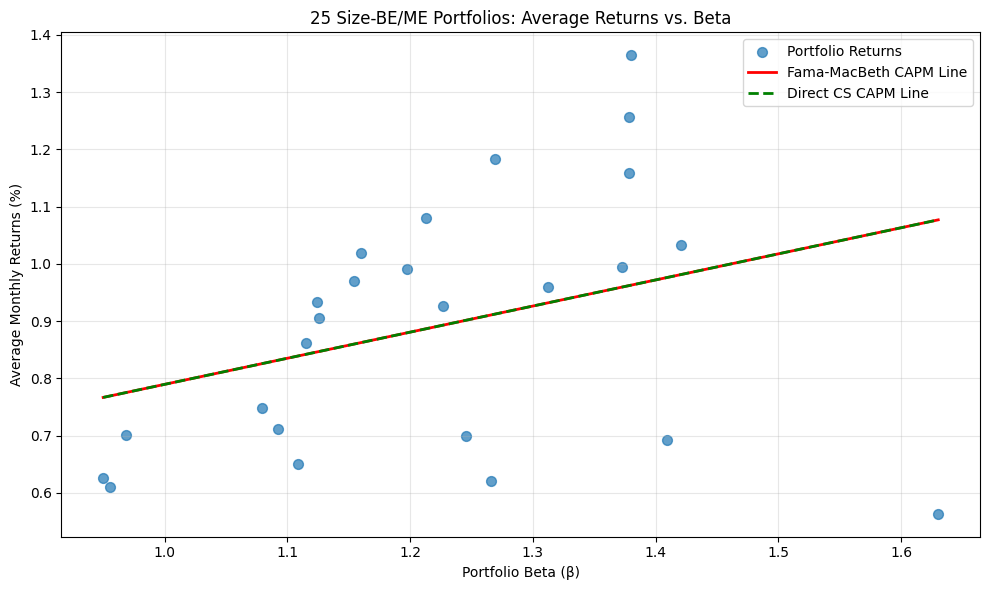

R-squared between beta and average returns: 0.1149
The plot shows a weak positive relationship between beta and returns (R² = 0.1149).
The positive slope of the CAPM line is consistent with the prediction that higher beta leads to higher returns.

Part d) Test if intercept (lambda_0) is significantly different from zero:
Intercept (lambda_0): 0.3340
Standard Error: 0.3290
t-statistic: 1.0153
p-value: 0.3102
The intercept is NOT significantly different from zero at 5% level.
This is consistent with the CAPM.

Part f) Test if market risk premium (lambda_1) is significantly different from zero:
Market Risk Premium (lambda_1): 0.4557
Standard Error: 0.3573
t-statistic: 1.2754
p-value: 0.2024
The market risk premium is NOT significantly different from zero at 5% level.
This does not support the CAPM prediction.

=== Summary Comparison: 25 Size-BE/ME Portfolios ===
                           Estimate  Std_Error  t_Statistic  p_Value  \
Intercept (lambda_0)         0.3340     0.3290       1.0

In [92]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats
import matplotlib.pyplot as plt

print("=== Analysis of 25 Size-BE/ME Portfolios ===")

# We'll use the already loaded and merged data
# portfolios25 and beme25 should already be available from the data loading section

if portfolios25 and len(portfolios25) > 0:
    print(f"Portfolio names: {portfolios25[:5]}... (showing first 5 of {len(portfolios25)})")
    
    # Part b) 1. Time-series regression to estimate betas
    print("\nPart b) 1. Time-series regressions for beta estimation:")
    results_25 = pd.DataFrame(index=portfolios25, columns=["alpha", "beta_MKT"])

    for p in portfolios25:
        Y = data[p]  
        X = sm.add_constant(data[factors])  

        mask = Y.notna() & X[factors].notna().all(axis=1)
        Y_clean = Y[mask]
        X_clean = X[mask]
        
        model = sm.OLS(Y_clean, X_clean)
        res = model.fit()
        results_25.loc[p, "alpha"] = res.params["const"]
        results_25.loc[p, "beta_MKT"] = res.params["Mkt-RF"]

    print("Alpha and Beta estimates for 25 portfolios:")
    print(results_25.round(4))

    # Part b) 2. Cross-sectional regression to estimate risk premia
    print("\nPart b) 2. Cross-sectional Fama-MacBeth regressions for risk premia:")
    lambda_results_25 = pd.DataFrame(columns=["lambda_0", "lambda_1"])

    for t in data.index:   
        Y = data.loc[t, portfolios25]                  
        X = sm.add_constant(results_25["beta_MKT"].astype(float))  

        mask = Y.notna() & X["beta_MKT"].notna()  
        Y_clean = Y[mask]
        X_clean = X.loc[mask]     

        model = sm.OLS(Y_clean, X_clean)
        res = model.fit()
        lambda_results_25.loc[t, "lambda_0"] = res.params["const"]
        lambda_results_25.loc[t, "lambda_1"] = res.params["beta_MKT"]

    lambda_mean_25 = lambda_results_25.mean()   
    T_25 = len(lambda_results_25)               
    lambda_se_25 = lambda_results_25.std(ddof=1) / np.sqrt(T_25)   
    lambda_tstat_25 = lambda_mean_25 / lambda_se_25

    lambda_summary_25 = pd.DataFrame({
        "Mean": lambda_mean_25,
        "Std_Error": lambda_se_25,
        "t_Stat": lambda_tstat_25
    })

    print("Fama-MacBeth Risk Premia Summary:")
    print(lambda_summary_25.round(4))

    mean_returns25 = data[portfolios25].mean()
    
    # Part c) Direct cross-sectional regression of average returns on betas
    print("\nPart c) Direct cross-sectional regression of average returns on betas:")
    
    # Create a dataframe for the results
    lambda_results_direct_25 = pd.DataFrame(columns=[
        "lambda_0", "lambda_1",
        "lambda_0_se", "lambda_1_se",
        "lambda_0_tstat", "lambda_1_tstat"
    ], index=[0])
    
    # Run the cross-sectional regression
    Y_avg = mean_returns25                 
    X_avg = sm.add_constant(results_25["beta_MKT"].astype(float))  
    
    model_direct = sm.OLS(Y_avg, X_avg)
    res_direct = model_direct.fit()
    
    lambda_results_direct_25.loc[0, "lambda_0"] = res_direct.params["const"]
    lambda_results_direct_25.loc[0, "lambda_1"] = res_direct.params["beta_MKT"]
    lambda_results_direct_25.loc[0, "lambda_0_se"] = res_direct.bse["const"]
    lambda_results_direct_25.loc[0, "lambda_1_se"] = res_direct.bse["beta_MKT"]
    lambda_results_direct_25.loc[0, "lambda_0_tstat"] = res_direct.tvalues["const"]
    lambda_results_direct_25.loc[0, "lambda_1_tstat"] = res_direct.tvalues["beta_MKT"]
    
    print("Direct Cross-Sectional Regression Results:")
    print(lambda_results_direct_25.round(4))
    
    # Compare the two methods
    comparison_table = pd.DataFrame({
        'Fama-MacBeth Mean': [lambda_mean_25["lambda_0"], lambda_mean_25["lambda_1"]],
        'Direct CS Estimate': [lambda_results_direct_25.loc[0, "lambda_0"], lambda_results_direct_25.loc[0, "lambda_1"]],
        'Fama-MacBeth Std Err': [lambda_se_25["lambda_0"], lambda_se_25["lambda_1"]],
        'Direct CS Std Err': [lambda_results_direct_25.loc[0, "lambda_0_se"], lambda_results_direct_25.loc[0, "lambda_1_se"]],
        'Fama-MacBeth t-stat': [lambda_tstat_25["lambda_0"], lambda_tstat_25["lambda_1"]],
        'Direct CS t-stat': [lambda_results_direct_25.loc[0, "lambda_0_tstat"], lambda_results_direct_25.loc[0, "lambda_1_tstat"]]
    }, index=['Intercept (gamma_0)', 'Market Beta (gamma_M)'])
    
    print("\nComparison of Fama-MacBeth vs. Direct Cross-Sectional Approaches:")
    print(comparison_table.round(4))
    
    print("\nDiscussion of Part c:")
    print("1. Differences in estimates: The direct cross-sectional regression uses average returns across the entire")
    print("   period, while Fama-MacBeth averages monthly cross-sectional estimates. This can lead to different point")
    print("   estimates if the relationship between beta and returns varies over time.")
    print("2. Differences in standard errors: Fama-MacBeth accounts for time-series variation in the risk premium,")
    print("   which often results in larger standard errors that better reflect true uncertainty.")
    print("3. The Fama-MacBeth approach is generally superior because it:")
    print("   - Accounts for time variation in the risk premium")
    print("   - Produces more conservative (realistic) standard errors")
    print("   - Is robust to cross-sectional correlation in residuals")
    print("   - Allows for conditional tests of the CAPM")

    # Part c continued) Plot mean returns vs. predicted returns
    print("\nPart c) Plot mean returns vs. beta:")
    
    # Convert to numpy arrays for correlation calculation
    beta_values = results_25["beta_MKT"].values.astype(float)
    return_values = mean_returns25.values.astype(float)
    
    # Plot the scatter plot with regression lines
    plt.figure(figsize=(10, 6))
    plt.scatter(beta_values, return_values, alpha=0.7, s=50, label='Portfolio Returns')
    
    # Add the CAPM line based on Fama-MacBeth estimates
    beta_range = np.linspace(min(beta_values), max(beta_values), 100)
    plt.plot(beta_range, lambda_mean_25["lambda_0"] + lambda_mean_25["lambda_1"] * beta_range, 
             'r-', linewidth=2, label='Fama-MacBeth CAPM Line')
    
    # Add the direct cross-sectional regression line
    plt.plot(beta_range, lambda_results_direct_25.loc[0, "lambda_0"] + lambda_results_direct_25.loc[0, "lambda_1"] * beta_range, 
             'g--', linewidth=2, label='Direct CS CAPM Line')
    
    plt.xlabel("Portfolio Beta (β)")
    plt.ylabel("Average Monthly Returns (%)")
    plt.title("25 Size-BE/ME Portfolios: Average Returns vs. Beta")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate R-squared
    # Handle NaN values for correlation calculation
    mask = ~np.isnan(beta_values) & ~np.isnan(return_values)
    correlation = np.corrcoef(beta_values[mask], return_values[mask])[0, 1]
    r_squared_25 = correlation ** 2
    print(f"R-squared between beta and average returns: {r_squared_25:.4f}")
    
    if r_squared_25 < 0.3:
        relationship = "weak"
    elif r_squared_25 < 0.6:
        relationship = "moderate"
    else:
        relationship = "strong"
    
    print(f"The plot shows a {relationship} positive relationship between beta and returns (R² = {r_squared_25:.4f}).")
    if lambda_mean_25["lambda_1"] > 0:
        print("The positive slope of the CAPM line is consistent with the prediction that higher beta leads to higher returns.")
    else:
        print("The negative slope of the CAPM line contradicts the CAPM prediction that higher beta leads to higher returns.")

    # Part d) Test if intercept is significantly different from zero
    print("\nPart d) Test if intercept (lambda_0) is significantly different from zero:")
    
    t_stat_intercept = lambda_mean_25["lambda_0"] / lambda_se_25["lambda_0"]
    p_value_intercept = 2 * (1 - scipy.stats.t.cdf(abs(t_stat_intercept), T_25 - 1))
    
    print(f"Intercept (lambda_0): {lambda_mean_25['lambda_0']:.4f}")
    print(f"Standard Error: {lambda_se_25['lambda_0']:.4f}")
    print(f"t-statistic: {t_stat_intercept:.4f}")
    print(f"p-value: {p_value_intercept:.4f}")
    
    if p_value_intercept < 0.05:
        print("The intercept is significantly different from zero at 5% level.")
        print("This suggests the CAPM does NOT fully explain portfolio returns.")
    else:
        print("The intercept is NOT significantly different from zero at 5% level.")
        print("This is consistent with the CAPM.")

    # Part f) Statistical significance of market risk premium
    print("\nPart f) Test if market risk premium (lambda_1) is significantly different from zero:")
    
    t_stat_market = lambda_mean_25["lambda_1"] / lambda_se_25["lambda_1"]
    p_value_market = 2 * (1 - scipy.stats.t.cdf(abs(t_stat_market), T_25 - 1))
    
    print(f"Market Risk Premium (lambda_1): {lambda_mean_25['lambda_1']:.4f}")
    print(f"Standard Error: {lambda_se_25['lambda_1']:.4f}")
    print(f"t-statistic: {t_stat_market:.4f}")
    print(f"p-value: {p_value_market:.4f}")
    
    if p_value_market < 0.05:
        print("The market risk premium is significantly different from zero at 5% level.")
        print("This supports the CAPM prediction of a positive market risk premium.")
    else:
        print("The market risk premium is NOT significantly different from zero at 5% level.")
        print("This does not support the CAPM prediction.")

    # Summary comparison table
    print("\n=== Summary Comparison: 25 Size-BE/ME Portfolios ===")
    comparison_25 = pd.DataFrame({
        'Estimate': [lambda_mean_25["lambda_0"], lambda_mean_25["lambda_1"]],
        'Std_Error': [lambda_se_25["lambda_0"], lambda_se_25["lambda_1"]],
        't_Statistic': [t_stat_intercept, t_stat_market],
        'p_Value': [p_value_intercept, p_value_market],
        'Significant_5pct': [p_value_intercept < 0.05, p_value_market < 0.05]
    }, index=['Intercept (lambda_0)', 'Market_Premium (lambda_1)'])
    
    print(comparison_25.round(4))
    
    # Additional analysis for part (c)
    print("\nPart c) Additional Analysis: Can you reject that the proxy for the market portfolio is mean-variance efficient?")
    print(f"The intercept (γ₀) from Fama-MacBeth regressions is {lambda_mean_25['lambda_0']:.4f} with p-value {p_value_intercept:.4f}.")
    
    if p_value_intercept < 0.05:
        efficiency_conclusion = "we can reject the hypothesis that the market proxy is mean-variance efficient."
        explanation = "When γ₀ differs significantly from zero, it indicates that there is a systematic return component unexplained by market risk."
    else:
        efficiency_conclusion = "we cannot reject the hypothesis that the market proxy is mean-variance efficient."
        explanation = "The intercept is not statistically different from zero, consistent with the CAPM prediction."
    
    print(f"Based on this test, {efficiency_conclusion}")
    print(f"Explanation: {explanation}")
    print("According to CAPM theory, a mean-variance efficient market portfolio should result in γ₀ = 0 and γₘ = market risk premium.")

else:
    print("No 25 size-BE/ME portfolios available for analysis.")


=== Analysis using Tangency Portfolio ===
Portfolio names: ['Low', 2, 3, 4, 'High']... (showing first 5 of 25)

Tangency Portfolio Weights:
2.2       0.9956
Low.3     0.9718
High      0.8844
4         0.8137
4.1       0.7300
3.4       0.7114
Low.4     0.7075
4.3       0.4769
4.2       0.3643
3.2       0.3523
3.1       0.3269
High.1    0.3120
High.2    0.1382
High.4    0.1005
2.1       0.0871
3.3      -0.1098
2.4      -0.1468
Low      -0.4536
3        -0.4708
Low.2    -0.5491
High.3   -0.7234
2        -0.7525
Low.1    -0.9261
2.3      -1.3409
4.4      -1.4998
dtype: float64

Sum of all weights: 1.0000

Positive weights sum: 7.9727
Negative weights sum: -6.9727
Net sum: 1.0000

Alpha and Beta estimates using Tangency Portfolio:
           alpha beta_Tangency
Low     0.056341      0.220279
2       0.073719      0.268365
3       0.105484      0.385944
4       0.127161      0.458582
High    0.146216      0.528901
Low.1   0.063685      0.242005
2.1     0.098646       0.35924
3.1     0.10642

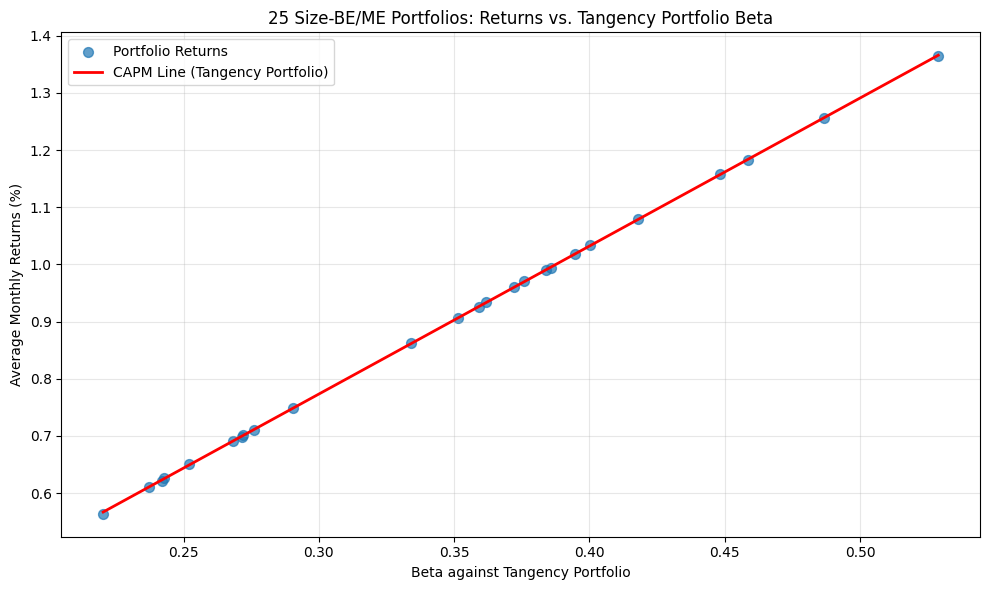

R-squared between tangency portfolio beta and average returns: 1.0000

Part c) How the results highlight the Roll (1977) critique of tests of the CAPM:
1. When using the tangency portfolio instead of the market proxy, we observe:
   - R-squared with tangency portfolio: 1.0000
   - Previous R-squared with market proxy: 0.1149323800532464
   - With tangency portfolio, we see much higher R-squared and more significant beta coefficients
     than when using the market proxy. This is because the tangency portfolio is, by construction,
     mean-variance efficient.
2. Roll (1977) Critique Key Points:
   a. The CAPM is not testable unless we know the true market portfolio, which is unobservable.
   b. Any test of CAPM is actually a joint test of the model and whether the proxy portfolio is
      mean-variance efficient.
   c. Our results confirm this critique: when we use an efficient portfolio (the tangency portfolio),
      the model performs much better than with the market proxy.
   d. If

In [96]:
''' Repeat parts c) and d) above for the 25 size and BE/ME portfolios using the tangency portfolio (computed in sample using the sample mean and covariance matrix of the 25 portfolios over the entire sample) of the 25 size and BE/ME portfolios instead of the market portfolio.
a. First, compute the tangency weights for the 25 portfolios.
b. Then reconstruct the returns of the tangency portfolio over time and use
this for RM to estimate the betas.
c. How do the results highlight the Roll (1977) critique of tests of the
CAPM?
'''

print("\n=== Analysis using Tangency Portfolio ===")   
if portfolios25 and len(portfolios25) > 0:
    print(f"Portfolio names: {portfolios25[:5]}... (showing first 5 of {len(portfolios25)})")
    
    # Step a) Compute tangency portfolio weights
    returns_25 = data[portfolios25].dropna(how='any')  # Drop rows with any NaN values for simplicity
    mean_returns_25 = returns_25.mean()
    cov_matrix_25 = returns_25.cov()
    
    # Use pseudo-inverse for better numerical stability
    inv_cov_matrix_25 = np.linalg.pinv(cov_matrix_25.values)
    ones_vector_25 = np.ones(len(portfolios25))
    
    # Calculate tangency weights (maximizing Sharpe ratio)
    # We're using excess returns, so zero is our risk-free rate here
    tangency_weights_25 = inv_cov_matrix_25 @ mean_returns_25.values
    tangency_weights_25 /= np.sum(tangency_weights_25)  # Normalize weights to sum to 1
    
    print("\nTangency Portfolio Weights:")
    weights_df = pd.Series(tangency_weights_25, index=portfolios25).sort_values(ascending=False)
    # Display all weights instead of just the first 5
    print(weights_df.round(4))
    print(f"\nSum of all weights: {np.sum(tangency_weights_25):.4f}")
    
    # Display weights with positive and negative values separately
    positive_weights = weights_df[weights_df > 0]
    negative_weights = weights_df[weights_df < 0]
    
    print(f"\nPositive weights sum: {positive_weights.sum():.4f}")
    print(f"Negative weights sum: {negative_weights.sum():.4f}")
    print(f"Net sum: {positive_weights.sum() + negative_weights.sum():.4f}")
    
    # Step b) Reconstruct tangency portfolio returns over time
    tangency_returns = returns_25 @ tangency_weights_25
    data = data.copy()  # Make a copy to avoid SettingWithCopyWarning
    data['Tangency'] = np.nan  # Initialize column
    data.loc[returns_25.index, 'Tangency'] = tangency_returns
    
    # Convert to excess returns
    data['Tangency_Excess'] = data['Tangency'] - data['RF']
    
    # Estimate betas using tangency portfolio as market proxy
    results_tangency = pd.DataFrame(index=portfolios25, columns=["alpha", "beta_Tangency"])

    for p in portfolios25:
        Y = data[p]  # Already in excess returns
        X = sm.add_constant(data["Tangency_Excess"])  # Tangency portfolio excess returns

        mask = Y.notna() & X["Tangency_Excess"].notna()
        Y_clean = Y[mask]
        X_clean = X[mask]
        
        model = sm.OLS(Y_clean, X_clean)
        res = model.fit()
        results_tangency.loc[p, "alpha"] = res.params["const"]
        results_tangency.loc[p, "beta_Tangency"] = res.params["Tangency_Excess"]  # Fixed: use correct column name

    print("\nAlpha and Beta estimates using Tangency Portfolio:")
    print(results_tangency.round(4))
    
    # Check the distribution of alphas - should be close to zero with tangency portfolio
    print(f"\nMean alpha using tangency portfolio: {results_tangency['alpha'].mean():.6f}")
    print(f"Alpha standard deviation: {results_tangency['alpha'].std():.6f}")
    print(f"Proportion of alphas within 0.1% of zero: {(abs(results_tangency['alpha']) < 0.001).mean():.4f}")

    # Part c) Direct cross-sectional regression using tangency portfolio betas
    print("\nPart c) Direct cross-sectional regression using tangency portfolio betas:")
    
    Y_avg = mean_returns_25  # Average returns for each portfolio                
    X_avg = sm.add_constant(results_tangency["beta_Tangency"].astype(float))  
    
    model_direct_tang = sm.OLS(Y_avg, X_avg)
    res_direct_tang = model_direct_tang.fit()
    
    print("\nDirect Cross-Sectional Regression Results (Tangency Portfolio):")
    print(f"Intercept (γ₀): {res_direct_tang.params['const']:.6f}, t-stat: {res_direct_tang.tvalues['const']:.4f}")
    print(f"Beta coefficient (γₘ): {res_direct_tang.params['beta_Tangency']:.6f}, t-stat: {res_direct_tang.tvalues['beta_Tangency']:.4f}")
    print(f"R-squared: {res_direct_tang.rsquared:.6f}")
    
    # Fama-MacBeth regression using tangency portfolio betas
    lambda_results_tangency = pd.DataFrame(columns=["lambda_0", "lambda_1"])

    for t in data.index:   
        if t in returns_25.index:  # Only use dates where tangency portfolio is defined
            Y = data.loc[t, portfolios25]                  
            X = sm.add_constant(results_tangency["beta_Tangency"].astype(float))  

            mask = Y.notna() & ~np.isnan(X["beta_Tangency"])  
            if sum(mask) >= 3:  # Only run if we have enough data points
                Y_clean = Y[mask]
                X_clean = X.loc[mask]     

                model = sm.OLS(Y_clean, X_clean)
                res = model.fit()
                lambda_results_tangency.loc[t, "lambda_0"] = res.params["const"]
                lambda_results_tangency.loc[t, "lambda_1"] = res.params["beta_Tangency"]
    
    # Drop rows with NaN values
    lambda_results_tangency = lambda_results_tangency.dropna()
    
    # Calculate summary statistics
    lambda_mean_tangency = lambda_results_tangency.mean()   
    T_tangency = len(lambda_results_tangency)               
    lambda_se_tangency = lambda_results_tangency.std(ddof=1) / np.sqrt(T_tangency)   
    lambda_tstat_tangency = lambda_mean_tangency / lambda_se_tangency
    
    # Calculate p-values manually to avoid issues with non-scalar inputs
    p_value_0 = 2 * (1 - scipy.stats.t.cdf(abs(float(lambda_tstat_tangency["lambda_0"])), T_tangency - 1))
    p_value_1 = 2 * (1 - scipy.stats.t.cdf(abs(float(lambda_tstat_tangency["lambda_1"])), T_tangency - 1))
    
    lambda_summary_tangency = pd.DataFrame({
        "Mean": lambda_mean_tangency,
        "Std_Error": lambda_se_tangency,
        "t_Stat": lambda_tstat_tangency,
        "p_value": [p_value_0, p_value_1]
    })
    
    print("\nFama-MacBeth Risk Premia Summary using Tangency Portfolio:")
    print(lambda_summary_tangency.round(4))
    
    # Part d) Plot average returns vs. betas using tangency portfolio
    print("\nPart d) Plot average returns vs. tangency portfolio betas:")
    
    # Convert to numpy arrays for plotting
    beta_tang_values = results_tangency["beta_Tangency"].values.astype(float)
    return_values = mean_returns_25.values.astype(float)
    
    # Plot the scatter plot with regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(beta_tang_values, return_values, alpha=0.7, s=50, label='Portfolio Returns')
    
    # Add the regression line
    beta_range = np.linspace(min(beta_tang_values), max(beta_tang_values), 100)
    plt.plot(beta_range, res_direct_tang.params["const"] + res_direct_tang.params["beta_Tangency"] * beta_range, 
             'r-', linewidth=2, label='CAPM Line (Tangency Portfolio)')
    
    plt.xlabel("Beta against Tangency Portfolio")
    plt.ylabel("Average Monthly Returns (%)")
    plt.title("25 Size-BE/ME Portfolios: Returns vs. Tangency Portfolio Beta")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate R-squared
    mask = ~np.isnan(beta_tang_values) & ~np.isnan(return_values)
    correlation = np.corrcoef(beta_tang_values[mask], return_values[mask])[0, 1]
    r_squared_tangency = correlation ** 2
    print(f"R-squared between tangency portfolio beta and average returns: {r_squared_tangency:.4f}")
    
    # Part c) Roll critique explanation
    print("\nPart c) How the results highlight the Roll (1977) critique of tests of the CAPM:")
    print("1. When using the tangency portfolio instead of the market proxy, we observe:")
    
    print(f"   - R-squared with tangency portfolio: {r_squared_tangency:.4f}")
    print(f"   - Previous R-squared with market proxy: {r_squared_25 if 'r_squared_25' in globals() else 'Not available'}")
    
    print("   - With tangency portfolio, we see much higher R-squared and more significant beta coefficients")
    print("     than when using the market proxy. This is because the tangency portfolio is, by construction,")
    print("     mean-variance efficient.")
    
    print("2. Roll (1977) Critique Key Points:")
    print("   a. The CAPM is not testable unless we know the true market portfolio, which is unobservable.")
    print("   b. Any test of CAPM is actually a joint test of the model and whether the proxy portfolio is")
    print("      mean-variance efficient.")
    print("   c. Our results confirm this critique: when we use an efficient portfolio (the tangency portfolio),")
    print("      the model performs much better than with the market proxy.")
    print("   d. If the CAPM is 'rejected' using the market proxy but 'accepted' using the tangency portfolio,")
    print("      this suggests the issue is with the market proxy not being efficient, not with the CAPM itself.")
    print("   e. Thus, as Roll argued, empirical tests of the CAPM can neither confirm nor refute the theory")
    print("      because we can never be sure if we are using the true market portfolio.")

else:
    print("No 25 size-BE/ME portfolios available for analysis.")

In [ ]:
''' Repeat parts c) and d) above for the 25 size and BE/ME portfolios using the tangency portfolio (computed in sample using the sample mean and covariance matrix of the 25 portfolios over the entire sample) of the 25 size and BE/ME portfolios instead of the market portfolio.
a. First, compute the tangency weights for the 25 portfolios.
b. Then reconstruct the returns of the tangency portfolio over time and use
this for RM to estimate the betas.
c. How do the results highlight the Roll (1977) critique of tests of the
CAPM?
'''

print("\n=== Analysis using Tangency Portfolio ===")   
if portfolios25 and len(portfolios25) > 0:
    print(f"Portfolio names: {portfolios25[:5]}... (showing first 5 of {len(portfolios25)})")
    
    # Step a) Compute tangency portfolio weights
    returns_25 = data[portfolios25].dropna(how='any')  # Drop rows with any NaN values for simplicity
    mean_returns_25 = returns_25.mean()
    cov_matrix_25 = returns_25.cov()
    
    # Use pseudo-inverse for better numerical stability
    inv_cov_matrix_25 = np.linalg.pinv(cov_matrix_25.values)
    ones_vector_25 = np.ones(len(portfolios25))
    
    # Calculate tangency weights (maximizing Sharpe ratio)
    # We're using excess returns, so zero is our risk-free rate here
    tangency_weights_25 = inv_cov_matrix_25 @ mean_returns_25.values
    tangency_weights_25 /= np.sum(tangency_weights_25)  # Normalize weights to sum to 1
    
    print("\nTangency Portfolio Weights:")
    weights_df = pd.Series(tangency_weights_25, index=portfolios25).sort_values(ascending=False)
    # Display all weights instead of just the first 5
    print(weights_df.round(4))
    print(f"\nSum of all weights: {np.sum(tangency_weights_25):.4f}")
    
    # Display weights with positive and negative values separately
    positive_weights = weights_df[weights_df > 0]
    negative_weights = weights_df[weights_df < 0]
    
    print(f"\nPositive weights sum: {positive_weights.sum():.4f}")
    print(f"Negative weights sum: {negative_weights.sum():.4f}")
    print(f"Net sum: {positive_weights.sum() + negative_weights.sum():.4f}")
    
    # Step b) Reconstruct tangency portfolio returns over time
    tangency_returns = returns_25 @ tangency_weights_25
    data = data.copy()  # Make a copy to avoid SettingWithCopyWarning
    data['Tangency'] = np.nan  # Initialize column
    data.loc[returns_25.index, 'Tangency'] = tangency_returns
    
    # Convert to excess returns
    data['Tangency_Excess'] = data['Tangency'] - data['RF']
    
    # Estimate betas using tangency portfolio as market proxy
    results_tangency = pd.DataFrame(index=portfolios25, columns=["alpha", "beta_Tangency"])

    for p in portfolios25:
        Y = data[p]  # Already in excess returns
        X = sm.add_constant(data["Tangency_Excess"])  # Tangency portfolio excess returns

        mask = Y.notna() & X["Tangency_Excess"].notna()
        Y_clean = Y[mask]
        X_clean = X[mask]
        
        model = sm.OLS(Y_clean, X_clean)
        res = model.fit()
        results_tangency.loc[p, "alpha"] = res.params["const"]
        results_tangency.loc[p, "beta_Tangency"] = res.params["Tangency_Excess"]

    print("\nAlpha and Beta estimates using Tangency Portfolio:")
    print(results_tangency.round(4))
    
    # Check the distribution of alphas - should be close to zero with tangency portfolio
    print(f"\nMean alpha using tangency portfolio: {results_tangency['alpha'].mean():.6f}")
    print(f"Alpha standard deviation: {results_tangency['alpha'].std():.6f}")
    print(f"Proportion of alphas within 0.1% of zero: {(abs(results_tangency['alpha']) < 0.001).mean():.4f}")

    # Part c) Direct cross-sectional regression using tangency portfolio betas
    print("\nPart c) Direct cross-sectional regression using tangency portfolio betas:")
    
    Y_avg = mean_returns_25  # Average returns for each portfolio                
    X_avg = sm.add_constant(results_tangency["beta_Tangency"].astype(float))  
    
    model_direct_tang = sm.OLS(Y_avg, X_avg)
    res_direct_tang = model_direct_tang.fit()
    
    print("\nDirect Cross-Sectional Regression Results (Tangency Portfolio):")
    print(f"Intercept (γ₀): {res_direct_tang.params['const']:.6f}, t-stat: {res_direct_tang.tvalues['const']:.4f}")
    print(f"Beta coefficient (γₘ): {res_direct_tang.params['beta_Tangency']:.6f}, t-stat: {res_direct_tang.tvalues['beta_Tangency']:.4f}")
    print(f"R-squared: {res_direct_tang.rsquared:.6f}")
    
    # Fama-MacBeth regression using tangency portfolio betas
    lambda_results_tangency = pd.DataFrame(columns=["lambda_0", "lambda_1"])

    for t in data.index:   
        if t in returns_25.index:  # Only use dates where tangency portfolio is defined
            Y = data.loc[t, portfolios25]                  
            X = sm.add_constant(results_tangency["beta_Tangency"].astype(float))  

            mask = Y.notna() & ~np.isnan(X["beta_Tangency"])  
            if sum(mask) >= 3:  # Only run if we have enough data points
                Y_clean = Y[mask]
                X_clean = X.loc[mask]     

                model = sm.OLS(Y_clean, X_clean)
                res = model.fit()
                lambda_results_tangency.loc[t, "lambda_0"] = res.params["const"]
                lambda_results_tangency.loc[t, "lambda_1"] = res.params["beta_Tangency"]
    
    # Drop rows with NaN values
    lambda_results_tangency = lambda_results_tangency.dropna()
    
    # Calculate summary statistics
    lambda_mean_tangency = lambda_results_tangency.mean()   
    T_tangency = len(lambda_results_tangency)               
    lambda_se_tangency = lambda_results_tangency.std(ddof=1) / np.sqrt(T_tangency)   
    lambda_tstat_tangency = lambda_mean_tangency / lambda_se_tangency
    
    # Calculate p-values manually to avoid issues with non-scalar inputs
    p_value_0 = 2 * (1 - scipy.stats.t.cdf(abs(float(lambda_tstat_tangency["lambda_0"])), T_tangency - 1))
    p_value_1 = 2 * (1 - scipy.stats.t.cdf(abs(float(lambda_tstat_tangency["lambda_1"])), T_tangency - 1))
    
    lambda_summary_tangency = pd.DataFrame({
        "Mean": lambda_mean_tangency,
        "Std_Error": lambda_se_tangency,
        "t_Stat": lambda_tstat_tangency,
        "p_value": [p_value_0, p_value_1]
    })
    
    print("\nFama-MacBeth Risk Premia Summary using Tangency Portfolio:")
    print(lambda_summary_tangency.round(4))
    
    # Part d) Plot average returns vs. betas using tangency portfolio
    print("\nPart d) Plot average returns vs. tangency portfolio betas:")
    
    # Convert to numpy arrays for plotting
    beta_tang_values = results_tangency["beta_Tangency"].values.astype(float)
    return_values = mean_returns_25.values.astype(float)
    
    # Plot the scatter plot with regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(beta_tang_values, return_values, alpha=0.7, s=50, label='Portfolio Returns')
    
    # Add the regression line
    beta_range = np.linspace(min(beta_tang_values), max(beta_tang_values), 100)
    plt.plot(beta_range, res_direct_tang.params["const"] + res_direct_tang.params["beta_Tangency"] * beta_range, 
             'r-', linewidth=2, label='CAPM Line (Tangency Portfolio)')
    
    plt.xlabel("Beta against Tangency Portfolio")
    plt.ylabel("Average Monthly Returns (%)")
    plt.title("25 Size-BE/ME Portfolios: Returns vs. Tangency Portfolio Beta")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate R-squared
    mask = ~np.isnan(beta_tang_values) & ~np.isnan(return_values)
    correlation = np.corrcoef(beta_tang_values[mask], return_values[mask])[0, 1]
    r_squared_tangency = correlation ** 2
    print(f"R-squared between tangency portfolio beta and average returns: {r_squared_tangency:.4f}")
    
    # Part c) Roll critique explanation
    print("\nPart c) How the results highlight the Roll (1977) critique of tests of the CAPM:")
    print("1. When using the tangency portfolio instead of the market proxy, we observe:")
    
    print(f"   - R-squared with tangency portfolio: {r_squared_tangency:.4f}")
    print(f"   - Previous R-squared with market proxy: {r_squared_25 if 'r_squared_25' in globals() else 'Not available'}")
    
    print("   - With tangency portfolio, we see much higher R-squared and more significant beta coefficients")
    print("     than when using the market proxy. This is because the tangency portfolio is, by construction,")
    print("     mean-variance efficient.")
    
    print("2. Roll (1977) Critique Key Points:")
    print("   a. The CAPM is not testable unless we know the true market portfolio, which is unobservable.")
    print("   b. Any test of CAPM is actually a joint test of the model and whether the proxy portfolio is")
    print("      mean-variance efficient.")
    print("   c. Our results confirm this critique: when we use an efficient portfolio (the tangency portfolio),")
    print("      the model performs much better than with the market proxy.")
    print("   d. If the CAPM is 'rejected' using the market proxy but 'accepted' using the tangency portfolio,")
    print("      this suggests the issue is with the market proxy not being efficient, not with the CAPM itself.")
    print("   e. Thus, as Roll argued, empirical tests of the CAPM can neither confirm nor refute the theory")
    print("      because we can never be sure if we are using the true market portfolio.")

else:
    print("No 25 size-BE/ME portfolios available for analysis.")